## Model tuning

This notebook details the process of tuning the model. 

From this point forward, I will be modeling with a few to predicting a binary outcome - 'intervene' or 'not_intervene' and only use the 'transformed' data - that is, I will not be looking at the PCA dataset.

### Import libraries and datasets

In [1]:
import pandas as pd

X_train_transformed = pd.read_csv('../../data/X_train_transformed.csv')
#X_test_transformed = pd.read_csv('../../data/X_test_transformed.csv')
X_val_transformed = pd.read_csv('../../data/X_val_transformed.csv')
#X_train_pca = pd.read_csv('../../data/X_train_pca.csv')
#X_test_pca = pd.read_csv('../../data/X_test_pca.csv')
#X_val_pca = pd.read_csv('../../data/X_val_pca.csv')


y_train = pd.read_csv('../../data/y_train.csv')
#y_test = pd.read_csv('../../data/y_test.csv')
y_val = pd.read_csv('../../data/y_val.csv')

#### Refactoring the 'final_result' target variable

In [2]:
# copy the data
y_train_binary = y_train.copy()

# map values to 'intervene' and 'no_intervene'
y_train_binary.replace({'Pass': 'no_intervene', 'Distinction': 'no_intervene',
                        'Withdrawn': 'intervene', 'Fail': 'intervene'}, inplace=True)

y_val_binary = y_val.copy()
y_val_binary.replace({'Pass': 'no_intervene', 'Distinction': 'no_intervene',
                        'Withdrawn': 'intervene', 'Fail': 'intervene'}, inplace=True)


### Hyperparameter tuning

Because I have a validation set, I have decided to use the validation set to tune the hyperparameters of the model.

In future analyses, I will use cross-validation to tune the hyperparameters to make the analysis more robust but for this initial modelling, I will use the validation set.

In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


# hyperparameter grid for each model
lr_param_grid = {'C': [0.1, 1.0, 10.0, 100], 'penalty': ['l1', 'l2']}
dt_param_grid = {'max_depth': [None, 2, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_param_grid = {'n_estimators': [10, 50, 100, 200, 300], 'max_depth': [None, 2, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
svc_param_grid = {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
gnb_param_grid = {}  # GaussianNB has no hyperparameters

# models and their parameter grids
models = [
    ('LR', LogisticRegression(max_iter=10000), lr_param_grid),
    ('DT', DecisionTreeClassifier(), dt_param_grid),
    ('RF', RandomForestClassifier(), rf_param_grid),
    ('SVC', SVC(), svc_param_grid),
    ('KNN', KNeighborsClassifier(), knn_param_grid),
    ('GNB', GaussianNB(), gnb_param_grid)
]

# number of folds for k-fold cross-validation
n_folds = 5

# hyperparameter tuning and cross-validation for each model
accuracies = []
model_names = []
best_models = {}  

# hyperparameter tuning and cross-validation for each model
for model_name, model, param_grid in models:
    print(f"Model: {model_name}")
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=n_folds, shuffle=True), scoring='accuracy')
    grid_search.fit(X_train_transformed, y_train_binary.values.ravel())  
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    # evaluate the model on the separate validation set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val_transformed)
    accuracy = accuracy_score(y_val_binary, y_pred)
    accuracies.append(accuracy)
    model_names.append(model_name)
    print("Validation Set Accuracy:", accuracy)

    # save the best model from each classifier
    best_models[model_name] = best_model

    print()


Model: LR


c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Best Score: 0.919251524548341
Validation Set Accuracy: 0.9184160305343512

Model: DT
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score: 0.923545878667397
Validation Set Accuracy: 0.9184160305343512

Model: RF
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.933725648472332
Validation Set Accuracy: 0.9320928753180662

Model: SVC
Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9245002514095942
Validation Set Accuracy: 0.9243002544529262

Model: KNN
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Score: 0.923068959304811
Validation Set Accuracy: 0.9212786259541985

Model: GNB
Best Parameters: {}
Best Score: 0.9120407348186689
Validation Set Accuracy: 0.9134860050890585



In [16]:
print(model_names)
print(accuracies)

['LR', 'DT', 'RF', 'SVC', 'KNN', 'GNB']
[0.9184160305343512, 0.9184160305343512, 0.9320928753180662, 0.9243002544529262, 0.9212786259541985, 0.9134860050890585]


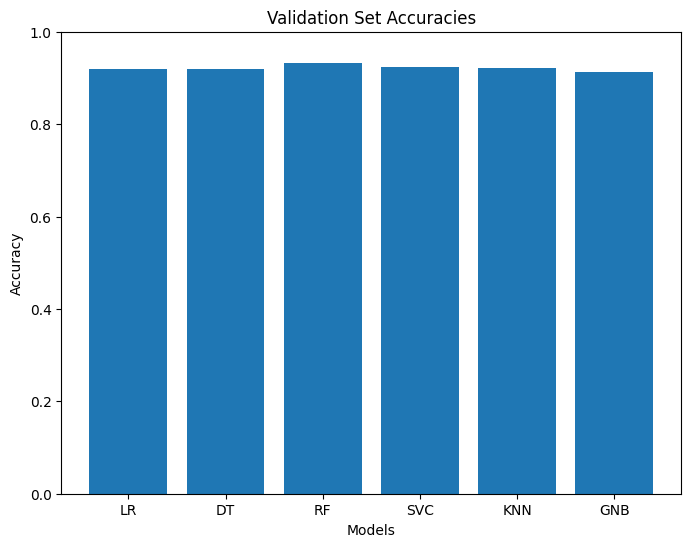

In [17]:

# plotting the accuracies
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracies')
plt.ylim([0, 1])
plt.show()


### Ensemble model from the best performing models

#### Voting classifier - Soft voting

In [28]:
# modify to probability True

best_models['SVC'].set_params(probability=True)


# ensemble model using the best models
ensemble_models = [('DT', best_models['DT']),
                   ('LR', best_models['LR']),
                   ('RF', best_models['RF']),
                   ('SVC', best_models['SVC']),
                   ('KNN', best_models['KNN']),
                   ('GNB', best_models['GNB'])]
                   

ensemble = VotingClassifier(estimators=ensemble_models, voting='soft', weights=[1, 1, 3, 2, 2, 1])

# fit the ensemble model 
ensemble.fit(X_train_transformed, y_train_binary.values.ravel())

# evaluate the ensemble model on the validation set
y_pred_ensemble = ensemble.predict(X_val_transformed)
accuracy_ensemble = accuracy_score(y_val_binary, y_pred_ensemble)
print("Ensemble Model Accuracy:", accuracy_ensemble)

Ensemble Model Accuracy: 0.9257315521628499


#### Voting classifier - Hard voting

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

# ensemble model using the best models
ensemble_models = [('DT', best_models['DT']),
                   ('LR', best_models['LR']),
                   ('RF', best_models['RF']),
                   ('SVC', best_models['SVC']),
                   ('KNN', best_models['KNN']),
                   ('GNB', best_models['GNB'])]

ensemble = VotingClassifier(estimators=ensemble_models, voting='hard')

# fit the ensemble model
ensemble.fit(X_train_transformed, y_train_binary.values.ravel())

# evaluate the ensemble model on the validation set
y_pred_ensemble = ensemble.predict(X_val_transformed)
accuracy_ensemble = accuracy_score(y_val_binary, y_pred_ensemble)
print("Ensemble Model Accuracy:", accuracy_ensemble)


Ensemble Model Accuracy: 0.9274809160305344


### Stacking Classifier



In [30]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# base models
base_models = [
    ('DT', DecisionTreeClassifier()),
    ('LR', LogisticRegression(max_iter=10000)),
    ('RF', RandomForestClassifier()),
    ('SVC', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('GNB', GaussianNB())
]

# meta-classifier
meta_model = LogisticRegression(max_iter=10000)

stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# fit the stacking classifier
stacking_classifier.fit(X_train_transformed, y_train_binary.values.ravel())

# evaluate the stacking classifier on the validation set
y_pred_stacking = stacking_classifier.predict(X_val_transformed)
accuracy_stacking = accuracy_score(y_val_binary, y_pred_stacking)
print("Stacking Classifier Accuracy:", accuracy_stacking)



Stacking Classifier Accuracy: 0.9317748091603053


#### Decision boundary plotting

been fighting this for hours - another day, another time.

c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: 'intervene'

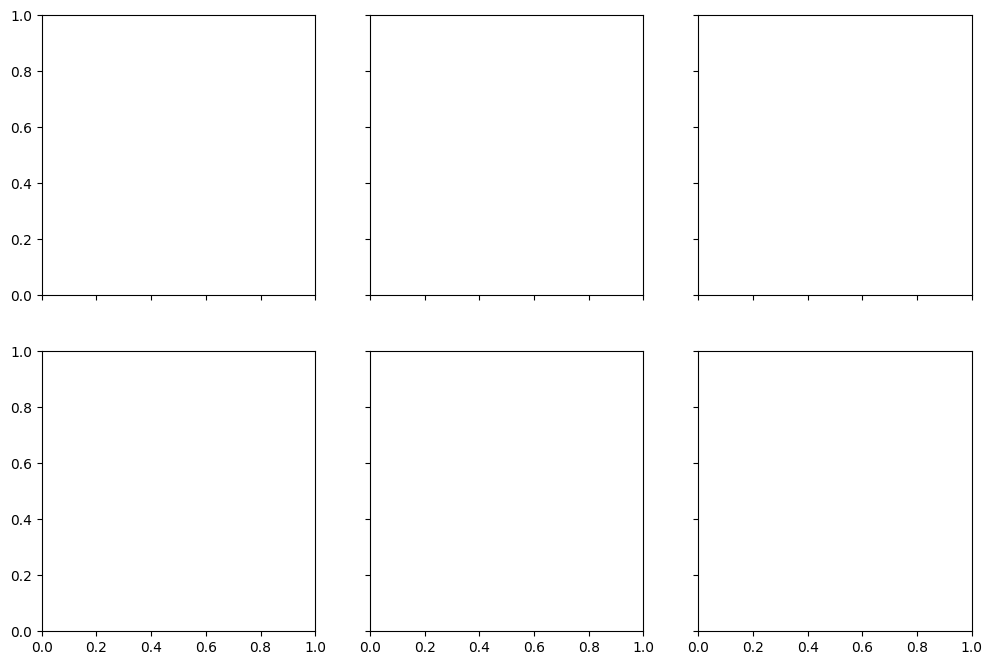

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from itertools import product

# best models
best_models = {
    'LR': LogisticRegression(C=0.1, max_iter=10000),
    'DT': DecisionTreeClassifier(max_depth=10, min_samples_leaf=4),
    'RF': RandomForestClassifier(min_samples_split=10, n_estimators=50),
    'SVC': SVC(C=10.0, probability=True),
    'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance'),
    'GNB': GaussianNB()
}

# fit models with transformed data
transformed_data = []
for features in product([0, 1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):
    X_train_transformed_subset = X_train_transformed.iloc[:, list(features)]
    transformed_data.append(X_train_transformed_subset)

for i, (model_name, clf) in enumerate(best_models.items()):
    clf.fit(transformed_data[i], y_train_binary.values.ravel())

# decision regions
x_min, x_max = transformed_data[0].iloc[:, 0].min() - 1, transformed_data[0].iloc[:, 0].max() + 1
y_min, y_max = transformed_data[0].iloc[:, 1].min() - 1, transformed_data[0].iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(12, 8))

for idx, (model_name, clf), tt in zip(range(6), best_models.items(),
                                      ['Decision Tree (depth=4)', 'KNN (k=7)',
                                       'Kernel SVM', 'Logistic Regression', 'Random Forest', 'Gaussian NB']):
    row_idx, col_idx = divmod(idx, 3)  # convert the index to row and column

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[row_idx, col_idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[row_idx, col_idx].scatter(transformed_data[idx].iloc[:, 0], transformed_data[idx].iloc[:, 1],
                                    c=y_train_binary, s=20, edgecolor='k')
    axarr[row_idx, col_idx].set_title(tt)

plt.tight_layout()
plt.show()







In [44]:
print(X_train_transformed.info())
print(y_train_binary.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18861 entries, 0 to 18860
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   subject_SocSci           18861 non-null  int64  
 1   subject_Stem             18861 non-null  int64  
 2   num_of_prev_attempts     18861 non-null  float64
 3   studied_credits          18861 non-null  float64
 4   prop_submissions         18861 non-null  float64
 5   avg_score                18861 non-null  float64
 6   submission_distance      18861 non-null  float64
 7   stu_activity_count       18861 non-null  float64
 8   stu_activity_type_count  18861 non-null  float64
 9   stu_total_clicks         18861 non-null  float64
 10  stu_days_active          18861 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 1.6 MB
None
(18861, 1)
